# **Práctico 5 (Parte 3): Cargar y explorar word embeddings pre-entrenados**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga de word embeddings pre entrenados con GloVe](#3.-Carga-de-word-embeddings-pre-entrenados-con-GloVe)
4. [Carga de datos de los dialogos](#4.-Carga-de-datos-de-los-dialogos)
5. [Palabras no presentes en el modelo pre entrenado](#5.-Palabras-no-presentes-en-el-modelo-pre-entrenado)
6. [Selección de vocabulario aleatorio](#6.-Selección-de-vocabulario-aleatorio)
7. [Nube de palabras y selección de vocabulario predominante](#7.-Nube-de-palabras-y-selección-de-vocabulario-predominante)
8. [Exploración de palabras por similitud](#8.-Exploración-de-palabras-por-similitud)
9. [Visualización](#9.-Visualización)
10. [Observaciones](#10.-Observaciones)

## 1. Consigna

En este ejercicio cargarán y explorarán word embeddings preentrenados, les recomiendo Glove usando la función most_similar y variando el valor de topn. Un tutorial sobre cómo hacerlo pueden encontrarse acá:

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Mostrar ejemplos usando most_similar que les resulten interesantes.

## 2. Inicialización del entorno

In [1]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import re
from ast import literal_eval
import itertools
import random

# Tratamiento de emojis
from utiles import convert_emojis
from utiles import convert_emoticons

# Para vectorizar los tokens
from sklearn.feature_extraction.text import CountVectorizer

# Embeddings
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Gráficos
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 3. Carga de word embeddings pre entrenados con GloVe 

Inicialmente vamos a explorar uno de los vectores de palabras preentrenados de dominio público disponibles en el website de GloVe de la Universidad de Stanford [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)

El archivo `glove.6B.zip` tiene las siguientes características: 

* Origen: Wikipedia 2014 + Gigaword 5 
* 6 mil millones de tokens
* Vocabulario: 400K  
* Minúsculas
* Vectores de 50d, 100d, 200d, & 300d 
* 822 MB 


In [2]:
data_dir = os.path.join('..', 'dataset')

#1. Archivo de entrada: GloVe
glove_input_file = 'glove.6B.100d.txt'
glove_input_file_full = os.path.join(data_dir, glove_input_file)

#2. Archivo de salida: Word2Vec 
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
word2vec_output_file_full = os.path.join(data_dir, word2vec_output_file)

#3. Conversión
glove2word2vec(glove_input_file_full, word2vec_output_file_full)

(400000, 100)

In [3]:
#4. Carga del modelo
model = KeyedVectors.load_word2vec_format(word2vec_output_file_full, binary=False)

In [4]:
#5. Tamaño del vocabulario
print('\nTamaño del vocabulario del modelo GloVe: {} palabras'.format(len(list(model.wv.vocab))))


Tamaño del vocabulario del modelo GloVe: 400000 palabras


## 4. Carga de datos de los dialogos

Nos interesa utilizar el modelo preentrenado para nuestro problema específico. Con ese objetivo cargamos los datos de los dialogos entre tutores y estudiantes para explorar el comportamiento con ese vocabulario particular 

In [5]:
#1. Carga de los datos de los dialogos
filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

#2. Remoción de las sesiones de pocos dialogos
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

#3. Remoción de los dialogos sin contenido
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

#4. Utilizamos expresiones regulares para unificar los unigramas bajo el tag <math>
r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

#5. Reemplazamos emojis
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: [convert_emojis(w) for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: [convert_emojis(w) for w in x])

#6. Reemplazamos emoticons
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: [convert_emoticons(w) for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: [convert_emoticons(w) for w in x])

#7 Convertimos a string
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: str(x)[1:-1])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: str(x)[1:-1])

#8. Unimos loa díalogos del tutor y del estudiante para vectorizarlos
datos_curados['tokens'] = datos_curados['tokens_tutor'] +', '+ datos_curados['tokens_student']
tokens = datos_curados['tokens']

In [6]:
#9. Utilizamos la técnica de Bag Of Words para reunir un vocabulario 
#vectorizer_dialogos_total = CountVectorizer(token_pattern=r'[^\s]+')
vectorizer_dialogos_total = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|:|!|\?|\"")

bow_total = vectorizer_dialogos_total.fit_transform(tokens)         
print('El vocabulario total consta de {} palabras provenientes de {} dialogos'
      .format(len(vectorizer_dialogos_total.vocabulary_),len(datos_curados)))

#10. Ahora vectorizamos:
vectorizer_dialogos = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|:|!|\?|\"")
bow = vectorizer_dialogos.fit_transform(tokens)         

print('Nos quedamos con un vocabulario de {} palabras provenientes de {} dialogos'
      .format(len(vectorizer_dialogos.vocabulary_),len(datos_curados)))

El vocabulario total consta de 35932 palabras provenientes de 16305 dialogos
Nos quedamos con un vocabulario de 35932 palabras provenientes de 16305 dialogos


Despues de inspeccionar los tokens de más baja frecuencia y más alta frecuencia decidimos no utilizar los parámetros `min_df` y `max_df` por las siguientes razones:

* Entre los términos de más alta frecuencia, hay algunos como `thanks` y `welcome` que pueden ser sumamente significativos para el objetivo del trabajo

* Entre los tokens de baja frecuencia hay expresiones simbólicas y palabras con errores ortográficos, pero también hay palabras que simplemente son infrecuentes pero que pensamos que el embedding puede considerar próximas a palabras con valor similar. Por esta razón en el paso siguiente donde segregamos aquellas palabras que no están en el embedding pre-entrenado vamos a descartar las primeras pero conservar las segundas que pueden tener impacto en la predicción

## 5. Palabras no presentes en el modelo pre-entrenado

Las palabras que no están incluidas en el modelo GloVe provocan una excepción cuando tratamos de procesarlas, por lo tanto debemos excluirlas del vocabulario con el que vamos a trabajar en el embedding.

Primero vamos a cuantificar y explorar cuantas y cuales de nuestras palabras no están en el modelo. Para tener una idea del impacto de esta limitación en el procesamiento

In [7]:
vocabulario_total  = [p for p in vectorizer_dialogos_total.get_feature_names() if p in model.wv.vocab]
palabras_no_presentes_total  = [p for p in vectorizer_dialogos_total.get_feature_names() if p not in model.wv.vocab]
print('\nEl vocabulario total de los dialogos tiene {} palabras.'
      .format(len(vocabulario_total)))
print('Hay {} palabras que no se encuentran en el modelo \n\n'
      .format(len(palabras_no_presentes_total), palabras_no_presentes_total))


El vocabulario total de los dialogos tiene 20245 palabras.
Hay 15687 palabras que no se encuentran en el modelo 




El [listado completo](Practico_5_part_3_a.md) de los tokens del vocabulario de los dialogos que no aparecen el modelo pre-entrenado puede verse aqui: [Practico_5_part_3_a.md](Practico_5_part_3_a.md)

Para realizar una caracterización rápida, podemos mencionar los siguientes tipos de tokens:

* Números o combinaciones de números con letras: `'00277778', '0027n', '003013', '0033', '0034', '00345', '0036', '003633', '175and176', '175j', '1760yards', '176by25', '177500', '177599541', '17908', '17984914', '179l'`

* Palabras mal escritas o variantes coloquiales de otra palabra. 
    * Por ejemplo para *derivative* aparecen estas: `'deriative', 'deriavative', 'deriavetive', 'derivaitive', 'derivaitve', 'derivarive', 'derivateive', 'derivatiev', 'derivating', 'derivatove', 'derivatve', 'deriviative', 'derivitave', 'derivtaive', 'derivtive', 'derivvative', 'derrivative',`  
    
    * o para *correct* `'coorect', 'corect', 'coreecr', 'coreect', 'coreesct', 'corerct', 'corerect', 'corext','corractly', 'corrcetly', 'corrct', 'corrdct',  'correc', 'correcct', 'correced', 'correcf', 'correclty' 'correcr', 'correct1', 'correctamundo', 'correcter', 'correctky', 'correctlt', 'correctlyn', 'correctq', 'correctt', 'correctv', 'correcty', 'correcy', 'correect', 'correecto', 'corret', 'corrext', 'corrextly',  'corrrct', 'corrrect',  'corrsct', 'corrwct', 'corrxt', 'cortect', `

* Palabras en otros lenguajes: `'дщщл', 'еру', 'ерштл', 'ефлу', 'здуфыуб', 'зкщидуью', 'кшпре', 'лфндф', 'нуы', 'нщг', 'нщгк', 'офыьшту', 'ршб', 'у1', 'у2', 'учфседн', 'фдкшпре', 'фе', 'фку', 'фцуыщьу', 'цудсщьу', 'ыгку', 'ыщ', 'ьщые', 'דבר', 'כן', 'שום', 'رمان', 'نعم', 'ياسر', 'يتقاضى'`

* O escritas utilzando símbolos no convencionales: `'ᑎᑌᗰᗷeᖇ', 'ᑕᗩᑎ', 'ᖴoᖇ', 'ᗩᑎy', 'ᗩᑕtᑌᗩᒪᒪy', 'ᗯeᒪᒪ', 'ᗯoᑎᗪeᖇiᑎg', 'ᗯᗩᔕ'`

In [8]:
vocabulario  = [p for p in vectorizer_dialogos.get_feature_names() if p in model.wv.vocab]
palabras_no_presentes  = [p for p in vectorizer_dialogos.get_feature_names() if p not in model.wv.vocab]
print('\nEl vocabulario de trabajo tiene {} palabras.'
      .format(len(vocabulario)))
print('Hay {} palabras que no se encuentran en el modelo: \n\n{}'
      .format(len(palabras_no_presentes), palabras_no_presentes))


El vocabulario de trabajo tiene 20245 palabras.
Hay 15687 palabras que no se encuentran en el modelo: 

['0000000', '000000000', '0000000000000000000000004', '0000000000000000000004', '00000000001', '000000000035', '0000000001', '000000000667', '000000001', '00000000227', '00000001', '000000010', '00000004290224', '0000001', '000000227', '000000333', '000000433926', '000000434', '000000625', '0000006708', '000001', '00000149253', '0000019557', '000001956', '0000038', '0000064', '00000980', '00001', '0000101325', '000033', '000034', '00004', '0000453864', '00005', '000054', '00006', '000064', '00007', '0000732', '000079', '00008428903', '00009118', '0001089', '000127727272727', '00012820512', '00013', '000146', '000146153846154', '0001464', '00014653846154', '00016574585', '00019230769', '0002', '0002mol', '0003', '0004', '00040', '000428', '000435', '000465', '0004780', '00050', '00052', '000567', '0006', '00063', '000631', '000678', '0006780', '0008', '000864', '00088367', '0008r', '

#### ¿Están emoticons y emojis en el modelo pre entrenado?

Sin hacerlo de forma exhaustiva vamos a comprobar si los emoticons y emojis están incluidos en el modelo mediante la comprobación de la existencia de los más comunes de aquellos

In [9]:
print ('{} contiene algunos emoticons'.format('Si' if  ':D' in model.wv.vocab or ':<' in model.wv.vocab else 'No'))

No contiene algunos emoticons


In [10]:
print ('{} contiene algunos emojis'.format('Si' if  '☺' in model.wv.vocab or '☻' in model.wv.vocab else 'No'))

No contiene algunos emojis


Emoticones: `':)', ':]',':D',':(',':<',';)', ... `

Emojis: 😄 ==> `':smiling_face_with_smiling_eyes:'` 😂 ==> `':face_with_tears_of_joy:'`  😔 ==> `':pensive_face:'` ...

## 6. Selección de vocabulario aleatorio

Vamos a seleccionar un vocabulario aleatorio proveniente de los dialogos en el cual vamos a realizar una exploración más detallada. A continuación eliminaremos aquellas palabras seleccionadas al azar que no estén en el modelo

In [11]:
#1 Elegimos 40 palabras al azar
vocabulario_aleatorio = random.sample(vectorizer_dialogos.get_feature_names(), 40)
print(vocabulario_aleatorio)

['poly1', 'counting', '2derivative', '0004780', '8571', '220000', 'appeared', '504', 'proerties', '1945', 'cabinet', 'mintue', 'invesre', 'dook', '75s', 'particularly', 'ban', 'jeans', 'awnset', 'arjun', '4x25', 'inspring', 'hungry', '0711', 'partiicular', 'paddled', 'cos70', 'makeing', 'whqt', '5c4', 'supply', 'alike', 'calcus', 'ctrl', 'neglecting', 'timed', 'rare', 'attacks', '9997', 'abbreviated']


In [12]:
# Eliminamos las palabras que no están en el modelo
vocabulario_descartado  = [p for p in vocabulario_aleatorio if p not in model.wv.vocab]
vocabulario_aleatorio  = [p for p in vocabulario_aleatorio if p in model.wv.vocab]
print('\nSe descartaron {} palabras que no se encuentran en el modelo: \n\n{}'
      .format(len(vocabulario_descartado), vocabulario_descartado))


Se descartaron 17 palabras que no se encuentran en el modelo: 

['poly1', '2derivative', '0004780', '8571', '220000', 'proerties', 'invesre', 'awnset', '4x25', 'inspring', 'partiicular', 'cos70', 'makeing', 'whqt', '5c4', 'calcus', '9997']


## 7. Nube de palabras y selección de vocabulario predominante

Para realizar una exploración más específica, decidimos seleccionar los términos que pueden resultar más relevantes y conformar un vocabulario con éstos. Para realizar esta selección decidimos usar una nube de palabras y luego seleccionar visualmente aquellos términos que pensamos que expresan mejor nuestro problema. 


In [13]:
#1. Seleccionamos los tokens correspondientes a los dialogos positivos y negativos
tokens_d_positivos = datos_curados['tokens'][datos_curados.student_rating_cat == 1 ]
tokens_d_negativos =  datos_curados['tokens'][datos_curados.student_rating_cat == 0 ]

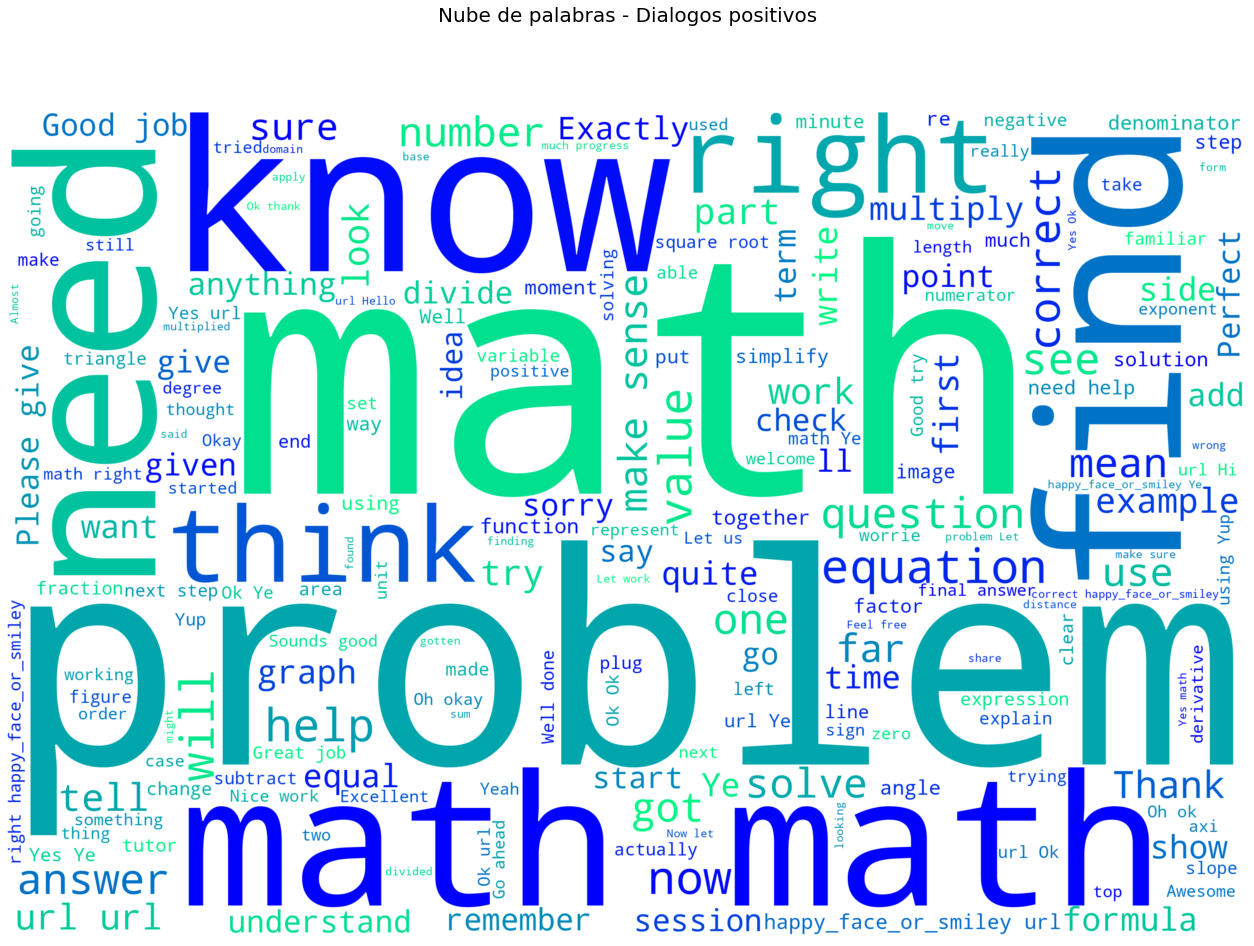

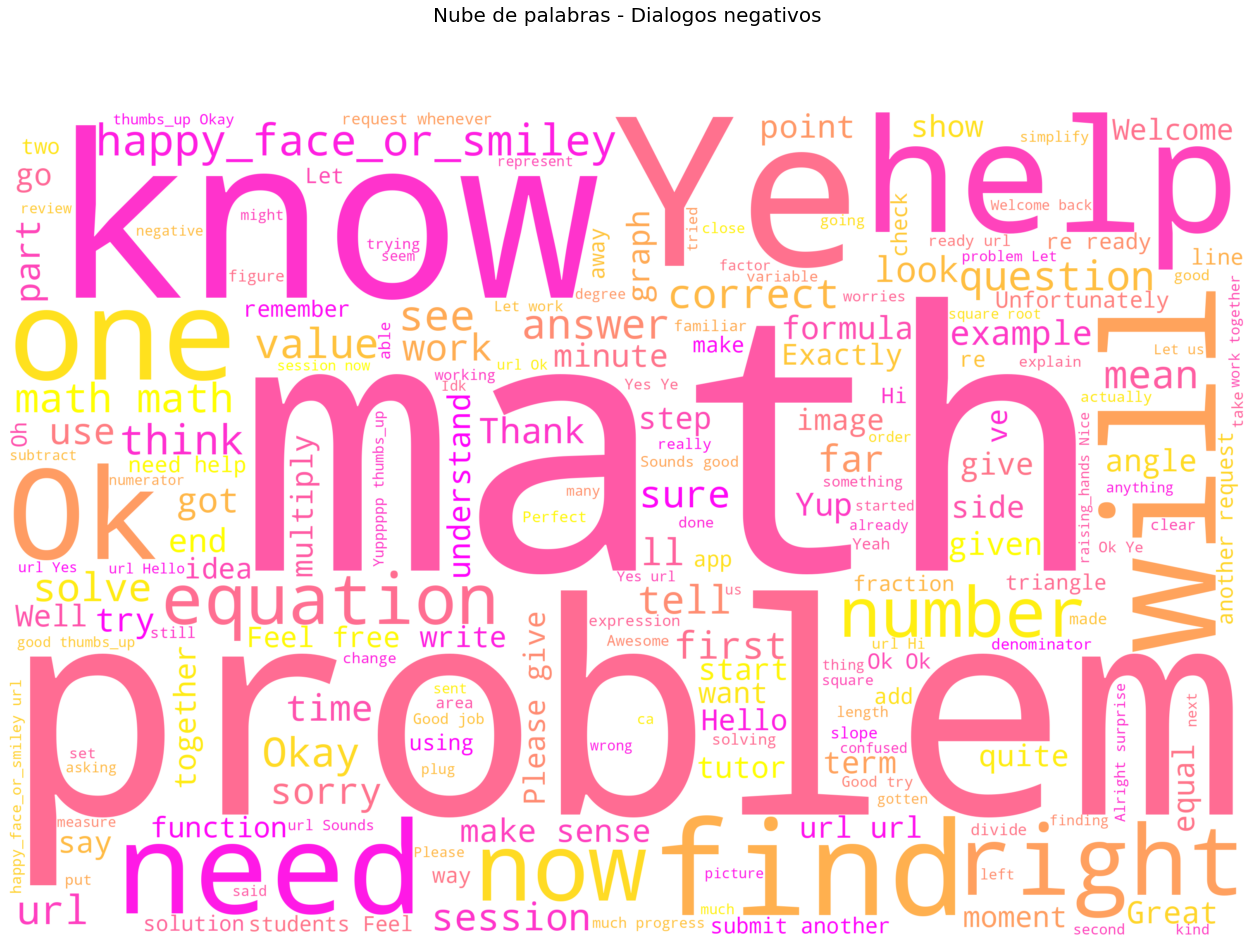

In [14]:
#2. Visualizamos los tokens de los dialogos positivos y negativos en nubes de palabras
texto_d_positivos = [x for x in tokens_d_positivos]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    colormap = 'winter',
    background_color = 'white').generate(str(texto_d_positivos))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'w',
    edgecolor = 'k')
fig.suptitle('Nube de palabras - Dialogos positivos', fontsize=20)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

texto_d_negativos = [x for x in tokens_d_negativos]

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    colormap = 'spring',
    background_color = 'white').generate(str(texto_d_negativos))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'w',
    edgecolor = 'k')
fig.suptitle('Nube de palabras - Dialogos negativos', fontsize=20)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

In [15]:
#3. A partir de estas nubes de palabras seleccionamos algunos tokens predominantes para procesarlos con el modelo
vocabulario_predominante = ['problem','know','find','think','help','sure','need','correct','answer','solve','idea','understand','right','tell','check','thank','see','good','ok','okay','awesome']

## 8. Exploración de palabras por similitud

Exploraremos algunos aspectos de nuestro vocabulario utilizando la capacidad del embedding de evaluar la similitud y aspectos relacionados.

Consignamos las primeras 6 palabras del vocabulario seleccionado y para cada una de ellas listamos los 5 vocablos mas similares con el score asociado. Conservamos esas palabras para poder visualizarlas en una etapa posterior. Haremos esto para el vocabulario aleatorio y el vocabulario predominante

#### 8.1. Busqueda de palabras más similares en el vocabulario aleatorio

In [16]:
grupos_similares_aleatorio = []
for p in range(6):
    palabras_similares = model.most_similar(vocabulario_aleatorio[p],topn=5)
    df_ms = pd.DataFrame(palabras_similares)
    grupos_similares_aleatorio.extend(list(df_ms[0]))
    grupos_similares_aleatorio.append(vocabulario_aleatorio[p])
    df_ms.columns = ['Palabra','Score']
    print('\nPalabras similares a la palabra: {} (top 5)\n'.format(vocabulario_aleatorio[p]))
    print(df_ms)


Palabras similares a la palabra: counting (top 5)

   Palabra     Score
0   voting  0.759069
1  ballots  0.716748
2  counted  0.698928
3   ballot  0.673730
4    votes  0.663693

Palabras similares a la palabra: appeared (top 5)

     Palabra     Score
0  appearing  0.812369
1     appear  0.810668
2    appears  0.773736
3      later  0.768386
4  initially  0.746825

Palabras similares a la palabra: 504 (top 5)

  Palabra     Score
0     503  0.865769
1     505  0.853414
2     506  0.836096
3     469  0.829875
4     424  0.826267

Palabras similares a la palabra: 1945 (top 5)

  Palabra     Score
0    1941  0.955756
1    1943  0.947056
2    1944  0.945126
3    1940  0.940828
4    1942  0.939025

Palabras similares a la palabra: cabinet (top 5)

      Palabra     Score
0   ministers  0.772840
1       prime  0.752453
2    minister  0.745081
3  parliament  0.719732
4   reshuffle  0.718739

Palabras similares a la palabra: mintue (top 5)

    Palabra     Score
0     seson  0.757046
1  goalf

#### 8.2. Busqueda de palabras más similares en el vocabulario predominante

In [17]:
grupos_similares_predominante = []
for p in range(6):
    palabras_similares = model.most_similar(vocabulario_predominante[p],topn=5)
    df_ms = pd.DataFrame(palabras_similares)
    grupos_similares_predominante.extend(list(df_ms[0]))
    grupos_similares_predominante.append(vocabulario_predominante[p])
    df_ms.columns = ['Palabra','Score']
    print('\nPalabras similares a la palabra: {} (top 5)\n'.format(vocabulario_predominante[p]))
    print(df_ms)


Palabras similares a la palabra: problem (top 5)

     Palabra     Score
0   problems  0.902954
1  situation  0.764082
2    because  0.760375
3   question  0.754780
4    trouble  0.751962

Palabras similares a la palabra: know (top 5)

  Palabra     Score
0     why  0.944094
1   think  0.922391
2     n't  0.921355
3    sure  0.914892
4     you  0.910305

Palabras similares a la palabra: find (top 5)

   Palabra     Score
0      get  0.839101
1     able  0.836775
2     come  0.827629
3     want  0.817973
4  finding  0.816319

Palabras similares a la palabra: think (top 5)

  Palabra     Score
0    know  0.922391
1  really  0.914028
2     why  0.908656
3     n't  0.907831
4      we  0.898287

Palabras similares a la palabra: help (top 5)

   Palabra     Score
0  helping  0.876881
1       to  0.860024
2    bring  0.841545
3   helped  0.830294
4   trying  0.806229

Palabras similares a la palabra: sure (top 5)

  Palabra     Score
0    know  0.914892
1     n't  0.903443
2      we  0.89773

#### 8.3. Exploramos el grado de similitud de 20 pares de palabras tomados aleatoriamente del vocabulario total

In [18]:
palabra0,palabra1,l_similitud = [],[],[]
for i in range(20):
    muestra = random.sample(vocabulario, 2)
    similitud = model.similarity(muestra[0], muestra[1])
    palabra0.append(muestra[0])
    palabra1.append(muestra[1])
    l_similitud.append(similitud)
    
    
s_palabras = {'Palabra 1': palabra0,
        'Palabra 2': palabra1,
        'Similitud': l_similitud
        }

df_similitud = pd.DataFrame(s_palabras, columns = ['Palabra 1', 'Palabra 2', 'Similitud'])  
df_similitud

,Palabra 1,Palabra 2,Similitud
0,cac,2006,0.092597
1,walk,safer,0.266658
2,margaery,computed,0.014661
3,mak,reporting,-0.043175
4,953,valleys,-0.030994
5,doe,designing,-0.114907
6,fuel,dishes,0.173076
7,prior,nano,-0.117030
8,cand,transitivity,0.117612
9,resend,alkyl,0.089765


#### 8.4. Buscamos la palabra más disimil de los conjuntos

El método `doesnt_match` obtiene la palabra más disimil usando la distancia coseno. Retorna la palabra con la máxima distancia coseno con respecto a las distancia coseno de todas las palabras del conjunto

In [19]:
#1. Obtenemos la palabra más disimil del vocabulario aleatorio
palabra_disimil_va = model.doesnt_match(vocabulario_aleatorio)
print (vocabulario_aleatorio)
print('\nLa palabra más disimil del vocabulario aleatorio es: {}'.format(palabra_disimil_va))

['counting', 'appeared', '504', '1945', 'cabinet', 'mintue', 'dook', '75s', 'particularly', 'ban', 'jeans', 'arjun', 'hungry', '0711', 'paddled', 'supply', 'alike', 'ctrl', 'neglecting', 'timed', 'rare', 'attacks', 'abbreviated']

La palabra más disimil del vocabulario aleatorio es: dook


In [20]:
#2. Obtenemos la palabra más disimil del vocabulario predominante
palabra_disimil_vp = model.doesnt_match(vocabulario_predominante)
print (vocabulario_predominante)
print('\nLa palabra más disimil del vocabulario predominante es: {}'.format(palabra_disimil_vp))

['problem', 'know', 'find', 'think', 'help', 'sure', 'need', 'correct', 'answer', 'solve', 'idea', 'understand', 'right', 'tell', 'check', 'thank', 'see', 'good', 'ok', 'okay', 'awesome']

La palabra más disimil del vocabulario predominante es: awesome


## 9. Visualización

#### Visualizamos el conjunto seleccionado aleatoriamente

Utilizamos PCA para proyectar el conjunto con el objeto de visualizarlo 

#### 9.1. Visualización del vocabulario aleatorio

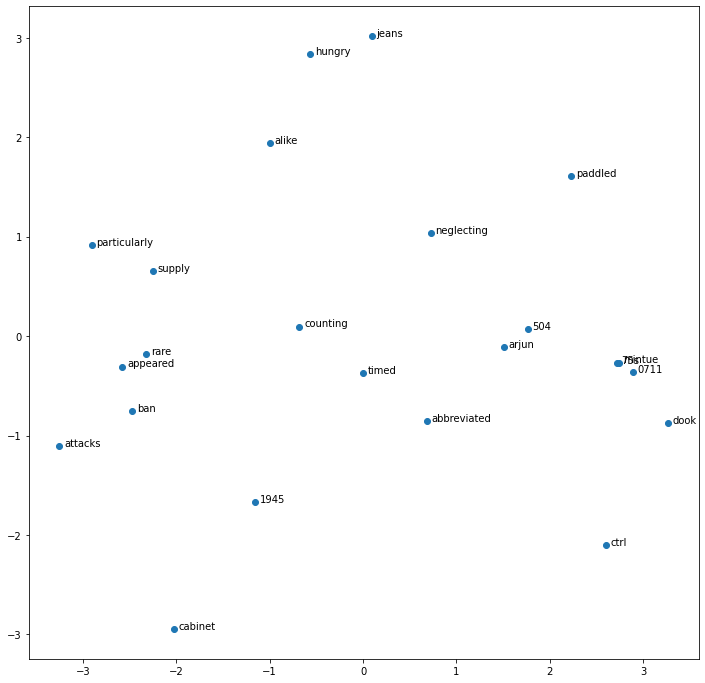

In [21]:
X = model[vocabulario_aleatorio]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


plt.figure(figsize=(12, 12))
plt.scatter(result[:, 0], result[:, 1])
words = list(vocabulario_aleatorio)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


#### 9.2. Visualización del vocabulario predominante

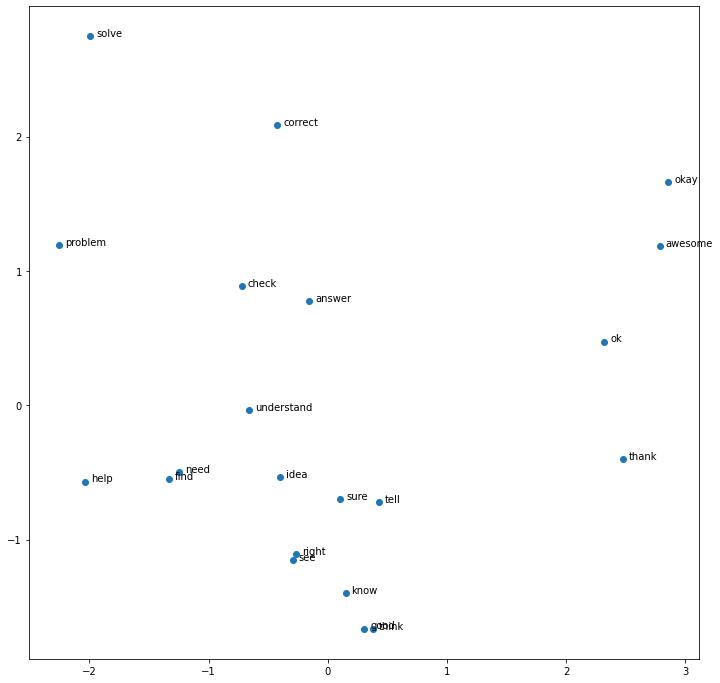

In [22]:
X = model[vocabulario_predominante]
pca = PCA(n_components=2)
result = pca.fit_transform(X)


plt.figure(figsize=(12, 12))
plt.scatter(result[:, 0], result[:, 1])
words = list(vocabulario_predominante)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


#### 9.3. Visualizamos los conjuntos de palabras similares en la selección aleatoria

Utilizando distintos colores para cada grupo, visualizamos el conjunto de palabras obtenidas utilizando `most_similar` sobre el vocabulario seleccionado aleatoriamente con el objeto de ver como se agrupan sus proyecciones

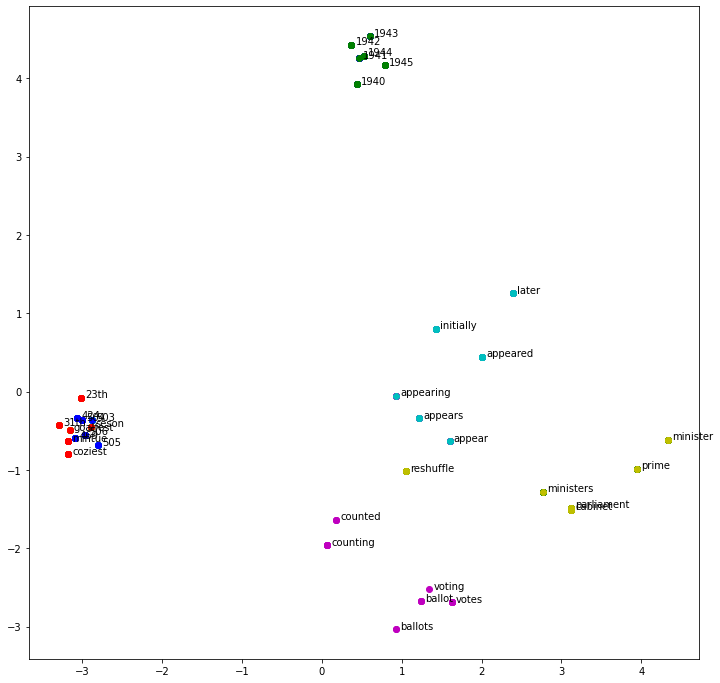

In [23]:
X = model[grupos_similares_aleatorio]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

colors = ["m","c", "b", "g","y","r"]

plt.figure(figsize=(12, 12))
#plt.scatter(result[:, 0], result[:, 1], color=next(colors))
words = list(grupos_similares_aleatorio)
for i, word in enumerate(words):
    plt.scatter(result[i:, 0], result[i:, 1], color=colors[i//6])
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


#### 9.4. Visualizamos los conjuntos de palabras similares en el vocabulario de palabras predominantes

Repetimos la operación sobre los grupos de palabras similares obtenidas a partir de la selección de las palabras más relevantes

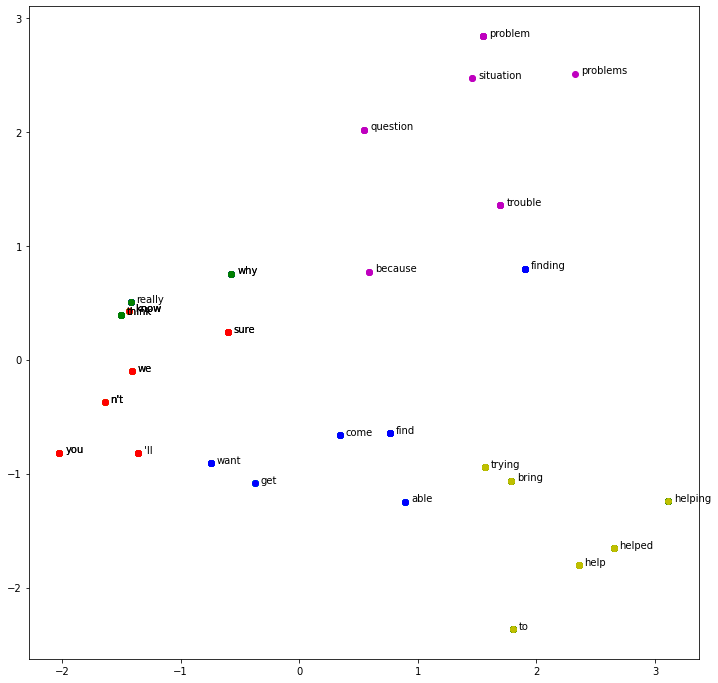

In [24]:
X = model[grupos_similares_predominante]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

colors = ["m","c", "b", "g","y","r"]

plt.figure(figsize=(12, 12))
#plt.scatter(result[:, 0], result[:, 1], color=next(colors))
words = list(grupos_similares_predominante)
for i, word in enumerate(words):
    plt.scatter(result[i:, 0], result[i:, 1], color=colors[i//6])
    plt.annotate(word, xy=(result[i, 0]+0.05, result[i, 1]))
plt.show()


## 9. Observaciones

Una de las limitaciones que a priori parecía evidente en el modelo pre entrenado que es la imposibilidad de utilizar tokens del vocabulario del dominio que no existen en el modelo, parece no tener un impacto tan grande medido en cantidad de palabras. 
Por supuesto que también hay otro aspecto que no hemos abordado aquí que es el hecho de que el embedding ha sido entrenado con un corpus en el que la relación entre las palabras no es la misma que en nuestro problema, por tanto es esperable que elementos como la utilización del lenguaje coloquial no aparezcan consideradas correctamente en el modelo pre entrenado